In [26]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report, precision_recall_curve


In [27]:
path = r"C:\Users\GREEN ARW\OneDrive\Desktop\Machine Learning\Data\WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(path)

In [28]:
print(df.shape)
print(df.columns.tolist())
df.head()

(7043, 21)
['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [29]:
df.columns = df.columns.str.strip()

In [30]:
# معلومات عامة
print(df.info())
print(df.describe(include='all').T)

# نسب القيم المفقودة
print(df.isnull().mean().sort_values(ascending=False).head(20))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [31]:
# لو القيم 'Yes'/'No'
if df["Churn"].dtype == object:
    df["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})

# بعد التحويل تأكدي
print(df["Churn"].value_counts())

Churn
0    5174
1    1869
Name: count, dtype: int64


In [32]:
print("duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("duplicates after:", df.duplicated().sum())

duplicates before: 0
duplicates after: 0


In [33]:
for col in df.columns:
    if df[col].isnull().sum() > 0:
        if pd.api.types.is_numeric_dtype(df[col]):
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

In [34]:
print(df.isnull().sum().sum())  # لازم يطلع 0

0


In [35]:
X = df.drop("Churn", axis=1)
y = df["Churn"].astype(int)

# تطبيق LabelEncoder لكل عمود نصي في X فقط
le = LabelEncoder()
for col in X.columns:
    if X[col].dtype == "object":
        X[col] = le.fit_transform(X[col].astype(str))

In [36]:
if 'customerID' in X.columns:
    X = X.drop('customerID', axis=1)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
# 1. SMOTE لمعالجة عدم التوازن
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [40]:
# 2. تدريب Logistic Regression
model = LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)
model.fit(X_train_res, y_train_res)

LogisticRegression(class_weight='balanced', max_iter=5000, random_state=42)

In [41]:
# 3. التنبؤ بالاحتمالات
y_pred_prob = model.predict_proba(X_test)[:, 1]

In [42]:
# 4. تجربة مجموعة thresholds
thresholds = np.arange(0.05, 1.0, 0.05)
best_recall = 0
best_threshold = 0
results = []

for t in thresholds:
    y_pred_class = (y_pred_prob >= t).astype(int)
    precision = precision_score(y_test, y_pred_class)
    recall = recall_score(y_test, y_pred_class)
    f1 = f1_score(y_test, y_pred_class)
    results.append((t, precision, recall, f1))
    
    if recall > best_recall:
        best_recall = recall
        best_threshold = t

In [43]:
# 5. طباعة النتائج
for t, p, r, f1 in results:
    print(f"Threshold: {t:.2f} | Precision: {p:.2f} | Recall: {r:.2f} | F1: {f1:.2f}")


Threshold: 0.05 | Precision: 0.35 | Recall: 0.98 | F1: 0.51
Threshold: 0.10 | Precision: 0.38 | Recall: 0.95 | F1: 0.54
Threshold: 0.15 | Precision: 0.40 | Recall: 0.94 | F1: 0.56
Threshold: 0.20 | Precision: 0.42 | Recall: 0.91 | F1: 0.57
Threshold: 0.25 | Precision: 0.43 | Recall: 0.88 | F1: 0.58
Threshold: 0.30 | Precision: 0.46 | Recall: 0.87 | F1: 0.60
Threshold: 0.35 | Precision: 0.48 | Recall: 0.82 | F1: 0.60
Threshold: 0.40 | Precision: 0.49 | Recall: 0.78 | F1: 0.61
Threshold: 0.45 | Precision: 0.51 | Recall: 0.76 | F1: 0.61
Threshold: 0.50 | Precision: 0.53 | Recall: 0.73 | F1: 0.61
Threshold: 0.55 | Precision: 0.54 | Recall: 0.68 | F1: 0.60
Threshold: 0.60 | Precision: 0.56 | Recall: 0.64 | F1: 0.60
Threshold: 0.65 | Precision: 0.58 | Recall: 0.58 | F1: 0.58
Threshold: 0.70 | Precision: 0.60 | Recall: 0.52 | F1: 0.56
Threshold: 0.75 | Precision: 0.63 | Recall: 0.43 | F1: 0.51
Threshold: 0.80 | Precision: 0.65 | Recall: 0.32 | F1: 0.43
Threshold: 0.85 | Precision: 0.66 | Reca

In [44]:
# 6. أفضل threshold
print(f"\n The best Threshold for Recall: {best_threshold} | Recall: {best_recall}")


 The best Threshold for Recall: 0.05 | Recall: 0.9803921568627451


In [45]:
# 7. تقرير التصنيف
y_pred_best = (y_pred_prob >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_best))

              precision    recall  f1-score   support

           0       0.98      0.33      0.49      1552
           1       0.35      0.98      0.51       561

    accuracy                           0.50      2113
   macro avg       0.66      0.65      0.50      2113
weighted avg       0.81      0.50      0.50      2113



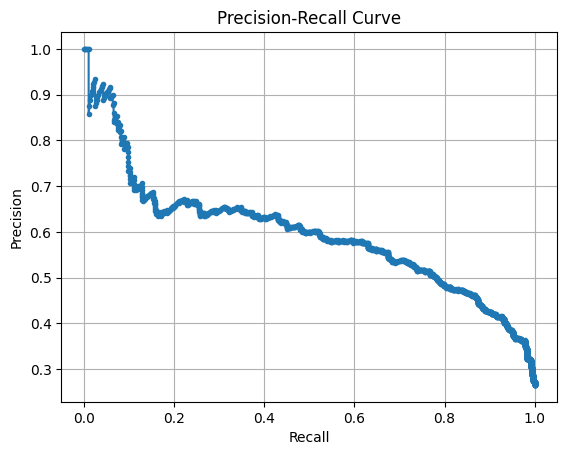

In [46]:
# 8. رسم Precision-Recall Curve
precisions, recalls, thres = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recalls, precisions, marker='.')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.grid()
plt.show()

In [47]:
# 9. حفظ الموديل
joblib.dump(model, r"..\models\logistic_regression_smote.pkl")
print("✅ The model has been saved. logistic_regression_smote.pkl")

✅ The model has been saved. logistic_regression_smote.pkl


In [48]:
model_loaded = joblib.load(r"..\models\logistic_regression_smote.pkl")


y_pred_prob = model_loaded.predict_proba(X_test)[:, 1]
y_pred_class = (y_pred_prob >= 0.05).astype(int)  



print(classification_report(y_test, y_pred_class))


              precision    recall  f1-score   support

           0       0.98      0.33      0.49      1552
           1       0.35      0.98      0.51       561

    accuracy                           0.50      2113
   macro avg       0.66      0.65      0.50      2113
weighted avg       0.81      0.50      0.50      2113

